<a href="https://colab.research.google.com/github/Amal-Baby-Mathews/Amal_TensorFlow2.0/blob/main/Recomendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552450 sha256=63f86b68344385dfcbbb24fba4c7da11dcf2ca3f25dffb03d411254f993ae47e
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from annoy import AnnoyIndex

# Initialize VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')



58889256/58889256 [==============================] - 2s 0us/step


In [3]:
!mkdir ~/.kaggle  # Create the directory if it doesn't exist
!echo '{"username":"amalml23","key":"5c67dbcce5a85dadf4b1e01d13fb1e88"}' > ~/.kaggle/kaggle.json
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): copyright-authors
100% 564M/565M [00:18<00:00, 40.9MB/s]
100% 565M/565M [00:18<00:00, 31.3MB/s]


In [4]:
!unzip /content/fashion-product-images-small.zip

Streaming output truncated to the last 5000 lines.
  inflating: myntradataset/images/5813.jpg  
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradataset/image

In [5]:
import csv
import os
import random
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import numpy as np

# VGG16 model and feature extraction
base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_path):
    """Extracts features from a product image using the pre-trained VGG16 model.

    Args:
        img_path (str): Path to the image file.

    Returns:
        np.ndarray: Flattened feature vector representing the image.
    """

    img = load_img(img_path, target_size=(224, 224))
    img_data = img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = base_model.predict(img_data)
    return features.flatten()

# Process CSV data (replace with your actual file path)
csv_file_path = '/content/myntradataset/styles.csv'
products = []
import itertools
with open(csv_file_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    # Print column names (optional, uncomment if needed)
    print(reader.fieldnames)

    for row in itertools.islice(reader, 10):
        # Extract product information from CSV (using new fieldnames)
        product_id = int(row['id'])  # Assuming 'id' replaces 'ProductID'
        name = row['productDisplayName']  # Assuming 'productDisplayName' replaces 'ProductName'
        description = row[ 'usage']  # Optional
        brand = row['masterCategory']  # Assuming 'masterCategory' replaces 'ProductBrand'
        gender = row['gender']  # Assuming 'gender' remains the same
        season = row['season']  # Assuming price is a string, convert to float if needed

        # Assuming images are stored in a subdirectory named 'images' within the CSV directory
        image_dir = '/content/images'
        image_path = os.path.join(image_dir, f"{row['id']}.jpg")  # Assuming 'articleType' replaces 'ProductName' for image path
        # Extract image features (assuming image is downloaded)
        features = extract_features(image_path)

        # Create product dictionary and store information (using new fieldnames)
        product = {
            'id': product_id,
            'name': name,
            'description': description,  # Optional
            'brand': brand,  # New entry for brand
            'gender': gender,  # New entry for gender
            'season': season,  # Assuming price is a string, convert to float if needed
            'features': features,
            'image_path':image_path
        }
        products.append(product)

print(f"Processed {len(products)} products from CSV.")

['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']
1/1 [==============================] - 1s 552ms/step
Processed 10 products from CSV.


In [6]:
# Dimension of the feature vectors
feature_dim = len(products[0]["features"])

# Initialize the Annoy index
annoy_index = AnnoyIndex(feature_dim, 'angular')

# Add items to the index
for product in products:
    annoy_index.add_item(product["id"], product["features"])

# Build the index with a specified number of trees
annoy_index.build(n_trees=10)

True

In [11]:
print(products)

[{'id': 15970, 'name': 'Turtle Check Men Navy Blue Shirt', 'description': 'Casual', 'brand': 'Apparel', 'gender': 'Men', 'season': 'Fall', 'features': array([1.01920176e+00, 0.00000000e+00, 2.45124054e+00, 0.00000000e+00,
       5.33341646e-01, 1.07462227e-01, 4.86462921e-01, 0.00000000e+00,
       1.50264347e+00, 0.00000000e+00, 1.43402648e+00, 3.48769248e-01,
       5.73905039e+00, 0.00000000e+00, 1.09355867e+00, 0.00000000e+00,
       6.95918620e-01, 0.00000000e+00, 0.00000000e+00, 4.63646030e+00,
       0.00000000e+00, 0.00000000e+00, 5.83945322e+00, 6.12164450e+00,
       5.15346192e-02, 1.52415171e-01, 9.01453733e-01, 9.61638927e-01,
       2.05964088e+00, 7.10308552e-01, 9.25925672e-01, 3.98952007e-01,
       3.01877022e+00, 0.00000000e+00, 4.90177822e+00, 7.62605011e-01,
       1.78491652e+00, 1.55713451e+00, 0.00000000e+00, 0.00000000e+00,
       1.47525430e-01, 0.00000000e+00, 6.64527035e+00, 1.92304885e+00,
       5.63303232e+00, 1.12338297e-01, 1.44016278e+00, 3.53628826e+0

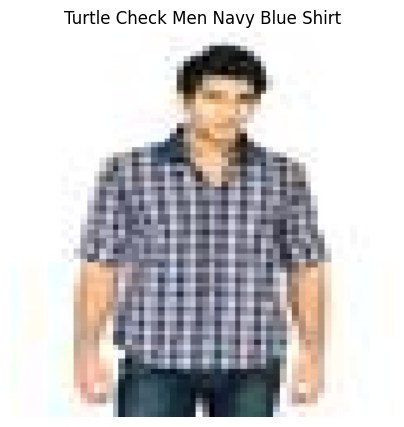

Neighbour ids [30805, 26960, 53759]
Recommended Product: Puma Men Grey T-shirt
Recommended Product: Fabindia Men Striped Green Shirt
Recommended Product: Jealous 21 Women Purple Shirt


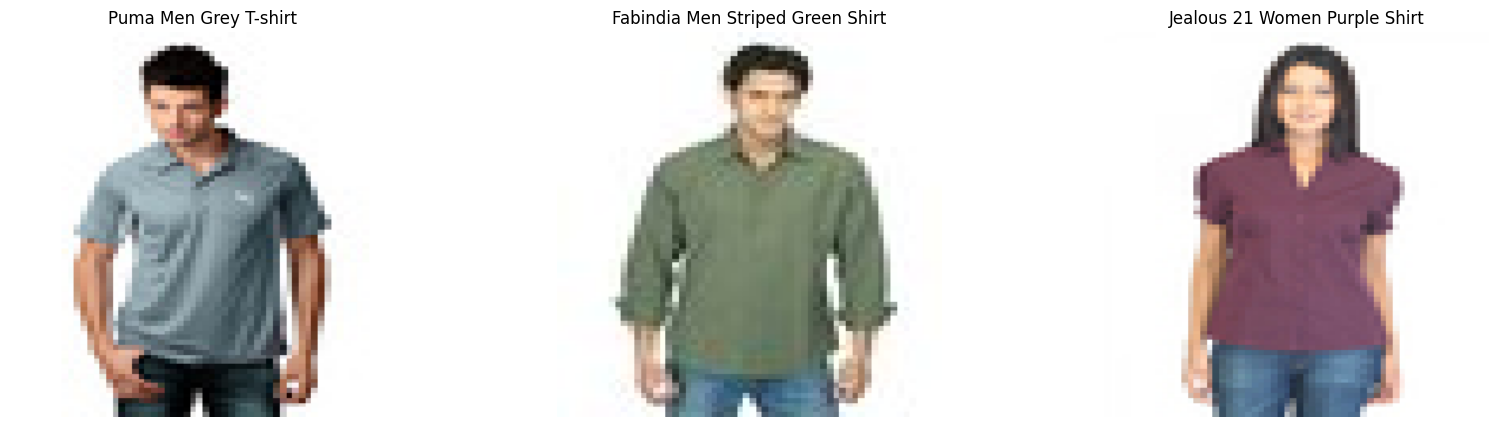

In [16]:
import matplotlib.pyplot as plt
def recommend_products(product_id, num_recommendations=3):
    """Recommend products based on the given product ID."""
    """Display images of the recommended products."""
    product= [product for product in products if product['id']==product_id]
    if product:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        img = image.load_img(product[0]["image_path"], target_size=(224, 224))
        ax.imshow(img)
        ax.set_title(product[0]["name"])
        ax.axis('off')
        plt.show()
    else:
        print(f"Product with ID {product_id} not found.")
    # Get the nearest neighbors
    neighbor_ids = annoy_index.get_nns_by_item(product_id, num_recommendations + 1)  # +1 because the item itself will be included
    neighbor_ids = [nid for nid in neighbor_ids if nid != product_id]  # Exclude the item itself
    print("Neighbour ids",neighbor_ids)
    # Retrieve product details for the recommended products
    recommended_products = [product for product in products if product["id"] in neighbor_ids]
    return recommended_products

def display_images(products):
    """Display images of the recommended products."""
    fig, axes = plt.subplots(1, len(products), figsize=(20, 5))
    for ax, product in zip(axes, products):
        img = image.load_img(product["image_path"], target_size=(224, 224))
        ax.imshow(img)
        ax.set_title(product["name"])
        ax.axis('off')
    plt.show()

# Example usage
recommended = recommend_products(15970, num_recommendations=3)
for product in recommended:
    print(f"Recommended Product: {product['name']}")
display_images(recommended)